# Prerequisites and imports

In [1]:
from pathlib import Path
import pandas as pd
from ordered_set import OrderedSet
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import json
from yaml.loader import SafeLoader
import ast

# loading yeast metabolic model

In [2]:
model_path = '/Users/philine/Downloads/yeast-GEM-8.6.2/model/yeast-GEM.yml'

In [3]:
with open(model_path) as file:
    data = yaml.load(file, Loader=yaml.FullLoader)

# loading csv file

In [5]:
csv = pd.read_csv('CSV.csv')
csv['INTERMEDIATES KEGG'] = csv['INTERMEDIATES KEGG'].apply(lambda x: ast.literal_eval(x))
csv['INTERMEDIATE NAMES'] = csv['INTERMEDIATE NAMES'].apply(lambda x: ast.literal_eval(x))
csv

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,REACTIONS,LENGTH SC.
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]","[Propene, 2-Propen-1-ol, Propenal, p-Coumarald...","['rat21804', 'rat10619', 'rat19578', 'rat19683...",0.2
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat45105', 'rat45020...",0.2
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44474...",0.2
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44476...",0.2
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44572...",0.2
...,...,...,...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat42928', 'rat4294...",0.2
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat42928', 'rat4286...",0.2
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat45380', 'rat4560...",0.2
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]","[Propene, 2-Propen-1-ol, Propenal, Caffeyl ald...","['rat21804', 'rat10619', 'rat18116', 'rat18526...",0.2


# how many compounds in csv

In [8]:
pathways = [i for i in csv['INTERMEDIATES KEGG']]

In [9]:
len(pathways)

1727

In [47]:
comp_list = []

for i in pathways:
    for j in i:
        comp_list.append(j)

comp_list = list(set(comp_list))
length = len(comp_list)
print(f'there are {length} unique compounds')

there are 263 unique compounds


# map s_id to kegg compound

In [52]:
# get metabolites data 
# go to metabolite section in model data
data_met = data[1][1]

## create list with all kegg compound of yeast model

In [53]:
kegg_list = []

for b in data_met:
    # Initialize a flag variable to False for each row
    kegg_found = False

    for c in b:
        if c[0] == 'annotation':
            for d in c[1]:
                if d[0] == 'kegg.compound':
                    kegg_list.append(d[1])
                    # Set the flag variable to True if a KEGG compound ID is found
                    kegg_found = True

    # Append 'NA' once per row if no KEGG compound ID is found
    if not kegg_found:
        kegg_list.append('NA')

In [18]:
len(kegg_list)

2744

## get s ids from yeast model

In [54]:
sid_list = []

for a in data_met: 
    for b in a:
        if b[0] == 'id':
            sid_list.append(b[1])

In [20]:
len(sid_list)

2744

filter out only cytosolic metabolites (compartment c)

In [21]:
index_c = [index for index, value in enumerate(data_met) if value[2][1] == 'c']

In [22]:
len(index_c)

854

# create dataset of kegg ids and s ids

## all

In [23]:
all_mapped = pd.DataFrame()

all_mapped['S ID'] = sid_list
all_mapped['KEGG ID'] = kegg_list
all_mapped

,S ID,KEGG ID
0,s_0001,C00965
1,s_0002,C00965
2,s_0003,C00965
3,s_0004,C02493
4,s_0006,C04807
...,...,...
2739,s_4265,C15521
2740,s_4266,C15521
2741,s_4267,C05122
2742,s_4268,C05122


In [24]:
sk_all = dict(zip(all_mapped['S ID'], all_mapped['KEGG ID']))
len(sk_all)

2744

## cytosolic

In [25]:
sk_mapped = pd.DataFrame()

sk_mapped['S ID'] = sid_list
sk_mapped['KEGG ID'] = kegg_list
sk_mapped = sk_mapped.drop(index=sk_mapped.index[~sk_mapped.index.isin(index_c)])
sk_mapped

,S ID,KEGG ID
1,s_0002,C00965
5,s_0007,C11514
7,s_0009,C04411
8,s_0010,C04236
11,s_0013,NA
...,...,...
2735,s_4261,NA
2738,s_4264,C00957
2739,s_4265,C15521
2741,s_4267,C05122


In [26]:
sk_dict = dict(zip(sk_mapped['S ID'], sk_mapped['KEGG ID']))
len(sk_dict)

854

## export mapped cytosolic data frame

# map model to csv

In [28]:
# create new df and keep only necessary columns

compounds = csv.copy()
compounds.drop(['INTERMEDIATE NAMES', 'REACTIONS', 'LENGTH SC.'], axis=1, inplace = True)
compounds

,LENGTH,INTERMEDIATES KEGG
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]"
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]"
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]"
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]"
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]"
...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]"
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]"
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]"
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]"


In [29]:
# get rid of source and target compound

compounds['kegg compounds'] = [i[1:-1] for i in compounds['INTERMEDIATES KEGG']]   
compounds

,LENGTH,INTERMEDIATES KEGG,kegg compounds
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]","[C02001, C01471, C05608, C06561]"
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]","[C02001, C05855, C01600, C04608]"
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]","[C02001, C05855, C00842, C01460]"
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]","[C02001, C05855, C00842, C01714]"
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]","[C02001, C05855, C00842, C04608]"
...,...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[C00511, C04415, C00498, C04608]"
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[C00511, C04415, C00498, C01714]"
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]","[C00511, C04415, C04507, C04608]"
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]","[C02001, C01471, C10945, C15525]"


In [30]:
# create copy for later
all_matches = compounds.copy()

# find all pathways where every compound in kegg compounds is present in yeast model (PERCFECT MATCHES)

In [31]:
# create new column that checks for perfect matches
# 1 = true, 0 = false
compounds['perfect_match'] = [1 if all(c in kegg_list for c in row['kegg compounds']) 
                      else 0 for _, row in compounds.iterrows()]
compounds

,LENGTH,INTERMEDIATES KEGG,kegg compounds,perfect_match
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]","[C02001, C01471, C05608, C06561]",0
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]","[C02001, C05855, C01600, C04608]",0
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]","[C02001, C05855, C00842, C01460]",0
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]","[C02001, C05855, C00842, C01714]",0
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]","[C02001, C05855, C00842, C04608]",0
...,...,...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[C00511, C04415, C00498, C04608]",0
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[C00511, C04415, C00498, C01714]",0
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]","[C00511, C04415, C04507, C04608]",0
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]","[C02001, C01471, C10945, C15525]",0


In [32]:
# create data frame containing the matches
matches = pd.DataFrame(compounds)

matches = matches[matches['perfect_match'] == 1]

matches

,LENGTH,INTERMEDIATES KEGG,kegg compounds,perfect_match
436,3,"[C06547, C00511, C00163, A00704]","[C00511, C00163]",1
580,3,"[C06793, C06614, C00511, C00186]","[C06614, C00511]",1
709,2,"[C11505, C05979, C06142]",[C05979],1
721,4,"[C06793, C06614, C00511, C00163, A00704]","[C06614, C00511, C00163]",1
831,2,"[C06547, C00469, C00186]",[C00469],1
832,2,"[C06547, C00511, C00186]",[C00511],1
1247,4,"[C11505, C05979, C00479, C00232, A00704]","[C05979, C00479, C00232]",1
1248,4,"[C11505, C05979, C00479, C00163, A00704]","[C05979, C00479, C00163]",1
1275,3,"[C11505, C05979, C00469, C00186]","[C05979, C00469]",1
1614,3,"[C06547, C00469, C05979, C06142]","[C00469, C05979]",1


In [33]:
# get indices of matches
match_index = matches.index.tolist()
match_index

[436, 580, 709, 721, 831, 832, 1247, 1248, 1275, 1614]

In [34]:
# create dataframe from original csv file with all perfect macthes
matched_csv = csv.loc[match_index]
matched_csv

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,REACTIONS,LENGTH SC.
436,3,"[C06547, C00511, C00163, A00704]","[Ethylene, Acrylate, Propionate, Succinate]","['rat131441', 'rat6652', 'rat131398']",0.33
580,3,"[C06793, C06614, C00511, C00186]","[Vinyl chloride, trans-3-Chloroacrylic acid, A...","['rat131663', 'rat22204', 'rat132369']",0.33
709,2,"[C11505, C05979, C06142]","[Propene, Optal, n-Butanol]","['rat132428', 'rat24525']",0.50
721,4,"[C06793, C06614, C00511, C00163, A00704]","[Vinyl chloride, trans-3-Chloroacrylic acid, A...","['rat131663', 'rat22204', 'rat6652', 'rat131398']",0.25
831,2,"[C06547, C00469, C00186]","[Ethylene, Ethanol, L-Lactate]","['rat132375', 'rat131412']",0.50
832,2,"[C06547, C00511, C00186]","[Ethylene, Acrylate, L-Lactate]","['rat131441', 'rat132369']",0.50
1247,4,"[C11505, C05979, C00479, C00232, A00704]","[Propene, Optal, Propanal, 4-Oxobutanoate, Suc...","['rat132428', 'rat10706', 'rat131417', 'rat165...",0.25
1248,4,"[C11505, C05979, C00479, C00163, A00704]","[Propene, Optal, Propanal, Propionate, Succinate]","['rat132428', 'rat10706', 'rat16330', 'rat1313...",0.25
1275,3,"[C11505, C05979, C00469, C00186]","[Propene, Optal, Ethanol, L-Lactate]","['rat132428', 'rat25402', 'rat131412']",0.33
1614,3,"[C06547, C00469, C05979, C06142]","[Ethylene, Ethanol, Optal, n-Butanol]","['rat132375', 'rat25402', 'rat24525']",0.33


In [35]:
# get source-target pair from perfect match pathways 
for h in matched_csv['INTERMEDIATE NAMES']:
    print('perfect match source-target pair: ', h[0], ' - ', h[-1])

perfect match source-target pair:  Ethylene  -  Succinate
perfect match source-target pair:  Vinyl chloride  -  L-Lactate
perfect match source-target pair:  Propene  -  n-Butanol
perfect match source-target pair:  Vinyl chloride  -  Succinate
perfect match source-target pair:  Ethylene  -  L-Lactate
perfect match source-target pair:  Ethylene  -  L-Lactate
perfect match source-target pair:  Propene  -  Succinate
perfect match source-target pair:  Propene  -  Succinate
perfect match source-target pair:  Propene  -  L-Lactate
perfect match source-target pair:  Ethylene  -  n-Butanol


In [36]:
# create new column containing source-target pair
# define a lambda function to extract the first and last elements of a list
get_first_last = lambda h: [h[0], h[-1]]

# apply the lambda function to the 'column_1' column and assign the result to a new column
matched_csv['source_target'] = matched_csv['INTERMEDIATE NAMES'].apply(get_first_last)

matched_csv['source_target'] = [' - '.join(i) for i in matched_csv['source_target']]
matched_csv

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,REACTIONS,LENGTH SC.,source_target
436,3,"[C06547, C00511, C00163, A00704]","[Ethylene, Acrylate, Propionate, Succinate]","['rat131441', 'rat6652', 'rat131398']",0.33,Ethylene - Succinate
580,3,"[C06793, C06614, C00511, C00186]","[Vinyl chloride, trans-3-Chloroacrylic acid, A...","['rat131663', 'rat22204', 'rat132369']",0.33,Vinyl chloride - L-Lactate
709,2,"[C11505, C05979, C06142]","[Propene, Optal, n-Butanol]","['rat132428', 'rat24525']",0.50,Propene - n-Butanol
721,4,"[C06793, C06614, C00511, C00163, A00704]","[Vinyl chloride, trans-3-Chloroacrylic acid, A...","['rat131663', 'rat22204', 'rat6652', 'rat131398']",0.25,Vinyl chloride - Succinate
831,2,"[C06547, C00469, C00186]","[Ethylene, Ethanol, L-Lactate]","['rat132375', 'rat131412']",0.50,Ethylene - L-Lactate
832,2,"[C06547, C00511, C00186]","[Ethylene, Acrylate, L-Lactate]","['rat131441', 'rat132369']",0.50,Ethylene - L-Lactate
1247,4,"[C11505, C05979, C00479, C00232, A00704]","[Propene, Optal, Propanal, 4-Oxobutanoate, Suc...","['rat132428', 'rat10706', 'rat131417', 'rat165...",0.25,Propene - Succinate
1248,4,"[C11505, C05979, C00479, C00163, A00704]","[Propene, Optal, Propanal, Propionate, Succinate]","['rat132428', 'rat10706', 'rat16330', 'rat1313...",0.25,Propene - Succinate
1275,3,"[C11505, C05979, C00469, C00186]","[Propene, Optal, Ethanol, L-Lactate]","['rat132428', 'rat25402', 'rat131412']",0.33,Propene - L-Lactate
1614,3,"[C06547, C00469, C05979, C06142]","[Ethylene, Ethanol, Optal, n-Butanol]","['rat132375', 'rat25402', 'rat24525']",0.33,Ethylene - n-Butanol


## export perfect match csv

# plotting perfect matches

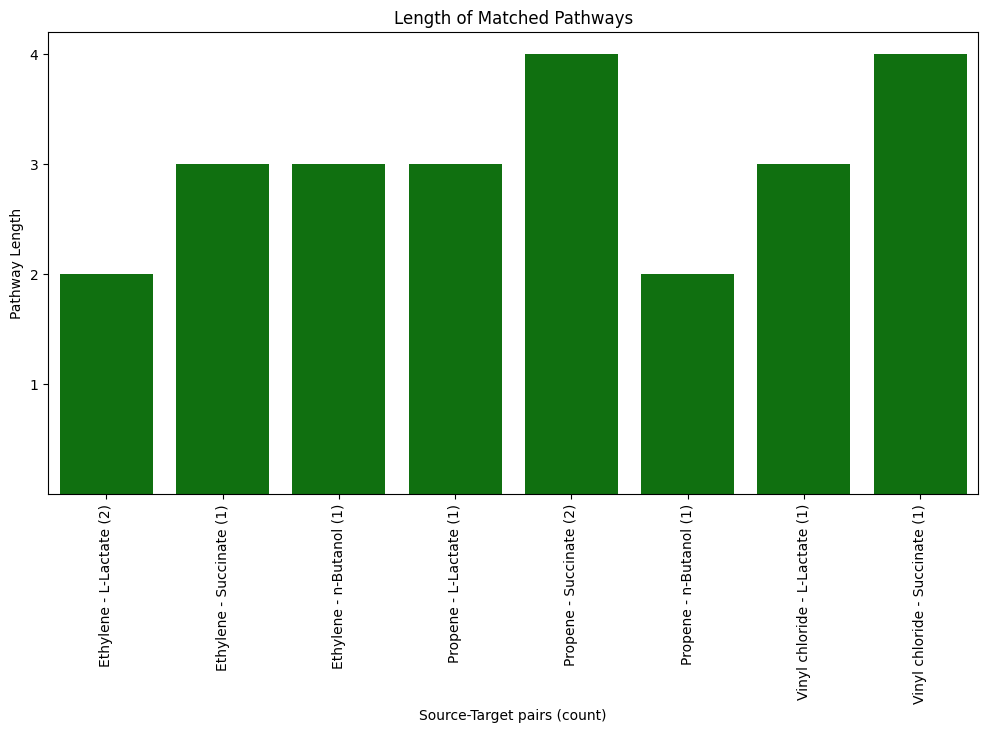

In [37]:
# Assuming you have a DataFrame called 'matched_csv' with columns 'source_target' and 'LENGTH'

# Create a new DataFrame with an additional column representing the count of occurrences of each source-target pair
grouped_matched_csv = matched_csv.groupby(['source_target', 'LENGTH']).size().reset_index(name='count')
grouped_matched_csv['source_target_count'] = grouped_matched_csv['source_target'] + ' (' + grouped_matched_csv['count'].astype(str) + ')'

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_matched_csv, x='source_target_count', y='LENGTH', color='green')

plt.xlabel('Source-Target pairs (count)')
plt.ylabel('Pathway Length')
plt.title('Length of Matched Pathways')

plt.yticks(range(min(grouped_matched_csv['LENGTH'])-1, max(grouped_matched_csv['LENGTH'])+1))

plt.xticks(rotation=90)

plt.show()


In [38]:
counts = [3, 4, 3]
lengths = [2, 3, 4]

total_length = sum([c * l for c, l in zip(counts, lengths)])
total_count = sum(counts)
mean_length = total_length / total_count

print(mean_length)

3.0


# find all pathways where not every compound in kegg compounds is present in yeast model (non PERCFECT MATCHES)

In [39]:
non_perfect = compounds.copy()
# get rid off perfect matches weil schon used above
#non_perfect = non_perfect[non_perfect['perfect_match'] == 0]
non_perfect['index'] = non_perfect.index

non_perfect

,LENGTH,INTERMEDIATES KEGG,kegg compounds,perfect_match,index
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]","[C02001, C01471, C05608, C06561]",0,0
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]","[C02001, C05855, C01600, C04608]",0,1
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]","[C02001, C05855, C00842, C01460]",0,2
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]","[C02001, C05855, C00842, C01714]",0,3
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]","[C02001, C05855, C00842, C04608]",0,4
...,...,...,...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[C00511, C04415, C00498, C04608]",0,1722
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[C00511, C04415, C00498, C01714]",0,1723
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]","[C00511, C04415, C04507, C04608]",0,1724
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]","[C02001, C01471, C10945, C15525]",0,1725


In [40]:
# get ids of pathways with at least one match
match_id = []
for u, row in non_perfect.iterrows():
    for v in kegg_list:
        if v in row['kegg compounds']:
            #print(v)
            match_id.append(u)

In [42]:
csv_final = pd.DataFrame(csv)
csv_final

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,REACTIONS,LENGTH SC.
0,5,"[C11505, C02001, C01471, C05608, C06561, C00509]","[Propene, 2-Propen-1-ol, Propenal, p-Coumarald...","['rat21804', 'rat10619', 'rat19578', 'rat19683...",0.2
1,5,"[C11505, C02001, C05855, C01600, C04608, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat45105', 'rat45020...",0.2
2,5,"[C11505, C02001, C05855, C00842, C01460, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44474...",0.2
3,5,"[C11505, C02001, C05855, C00842, C01714, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44476...",0.2
4,5,"[C11505, C02001, C05855, C00842, C04608, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...","['rat21804', 'rat19601', 'rat44607', 'rat44572...",0.2
...,...,...,...,...,...
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat42928', 'rat4294...",0.2
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat42928', 'rat4286...",0.2
1724,5,"[C06547, C00511, C04415, C04507, C04608, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...","['rat131441', 'rat19475', 'rat45380', 'rat4560...",0.2
1725,5,"[C11505, C02001, C01471, C10945, C15525, C05631]","[Propene, 2-Propen-1-ol, Propenal, Caffeyl ald...","['rat21804', 'rat10619', 'rat18116', 'rat18526...",0.2


In [43]:
for e, row in csv_final.iterrows():
    if e not in match_id:
        csv_final.drop(e, inplace = True)

csv_final['index'] = csv_final.index
csv_final = csv_final.drop(['REACTIONS', 'LENGTH SC.'], axis=1)
csv_final

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,index
17,5,"[C11505, C20464, C00530, C05608, C06561, C00509]","[Propene, Isochavicol, Quinol, p-Coumaraldehyd...",17
22,5,"[C11505, C02001, C05855, C00096, C01714, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...",22
23,5,"[C11505, C02001, C05855, C00031, C04608, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...",23
24,5,"[C11505, C02001, C05855, C00031, C09099, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...",24
30,5,"[C11505, C02001, C05855, C00096, C01460, C00509]","[Propene, 2-Propen-1-ol, 4-Hydroxycinnamyl alc...",30
...,...,...,...,...
1720,5,"[C06547, C00511, C04415, C00096, C01714, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...",1720
1721,5,"[C06547, C00511, C04415, C00096, C01460, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...",1721
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...",1722
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[Ethylene, Acrylate, 4-O-beta-D-Glucosyl-4-hyd...",1723


In [44]:
# drop rows with 0 matches

for e, row in non_perfect.iterrows():
    if e not in match_id:
        non_perfect.drop(e, inplace = True)
        
non_perfect

,LENGTH,INTERMEDIATES KEGG,kegg compounds,perfect_match,index
17,5,"[C11505, C20464, C00530, C05608, C06561, C00509]","[C20464, C00530, C05608, C06561]",0,17
22,5,"[C11505, C02001, C05855, C00096, C01714, C00509]","[C02001, C05855, C00096, C01714]",0,22
23,5,"[C11505, C02001, C05855, C00031, C04608, C00509]","[C02001, C05855, C00031, C04608]",0,23
24,5,"[C11505, C02001, C05855, C00031, C09099, C00509]","[C02001, C05855, C00031, C09099]",0,24
30,5,"[C11505, C02001, C05855, C00096, C01460, C00509]","[C02001, C05855, C00096, C01460]",0,30
...,...,...,...,...,...
1720,5,"[C06547, C00511, C04415, C00096, C01714, C01477]","[C00511, C04415, C00096, C01714]",0,1720
1721,5,"[C06547, C00511, C04415, C00096, C01460, C01477]","[C00511, C04415, C00096, C01460]",0,1721
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[C00511, C04415, C00498, C04608]",0,1722
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[C00511, C04415, C00498, C01714]",0,1723


In [45]:
csv_final.to_csv('non_perfect.csv', index=False)

In [46]:
# count number of matches per row
count_dict = dict(pd.Series(match_id).value_counts())

# Add a new column to the data frame with the occurrence count
non_perfect['match_num'] = non_perfect.index.map(count_dict)

non_perfect

,LENGTH,INTERMEDIATES KEGG,kegg compounds,perfect_match,index,match_num
17,5,"[C11505, C20464, C00530, C05608, C06561, C00509]","[C20464, C00530, C05608, C06561]",0,17,1
22,5,"[C11505, C02001, C05855, C00096, C01714, C00509]","[C02001, C05855, C00096, C01714]",0,22,3
23,5,"[C11505, C02001, C05855, C00031, C04608, C00509]","[C02001, C05855, C00031, C04608]",0,23,4
24,5,"[C11505, C02001, C05855, C00031, C09099, C00509]","[C02001, C05855, C00031, C09099]",0,24,4
30,5,"[C11505, C02001, C05855, C00096, C01460, C00509]","[C02001, C05855, C00096, C01460]",0,30,3
...,...,...,...,...,...,...
1720,5,"[C06547, C00511, C04415, C00096, C01714, C01477]","[C00511, C04415, C00096, C01714]",0,1720,4
1721,5,"[C06547, C00511, C04415, C00096, C01460, C01477]","[C00511, C04415, C00096, C01460]",0,1721,4
1722,5,"[C06547, C00511, C04415, C00498, C04608, C01477]","[C00511, C04415, C00498, C04608]",0,1722,1
1723,5,"[C06547, C00511, C04415, C00498, C01714, C01477]","[C00511, C04415, C00498, C01714]",0,1723,1


# all data, count number of pathways of specific length 

In [48]:
# all pathways, nicht nur non_perfect macthes
# count how many pathways have what differences

# group and count the number of pathways with a certain length
counts = csv['LENGTH'].value_counts()
counts = counts.sort_index()
counts

2      4
3     33
4    178
5    599
6    913
Name: LENGTH, dtype: int64

In [49]:
counts_list = [4, 33, 178, 599, 913]
lengths = [2, 3, 4, 5, 6]

total_length = sum([c * l for c, l in zip(counts_list, lengths)])
total_count = sum(counts_list)
mean_length = total_length / total_count

print(mean_length)

5.380428488708744


In [50]:
# von non_perfect, idk if useful 
counts_non = non_perfect['LENGTH'].value_counts()
counts_non = counts_non.sort_index()
counts_non

2      3
3     25
4    109
5    361
6    809
Name: LENGTH, dtype: int64

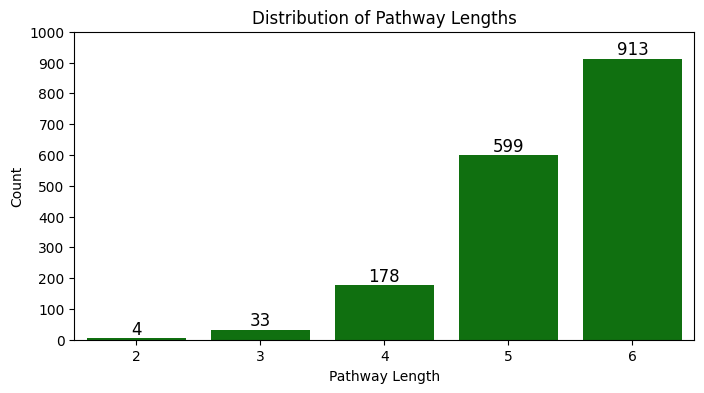

In [51]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=counts.index, y=counts.values, color='green')

plt.xlabel('Pathway Length')
plt.ylabel('Count')
plt.title('Distribution of Pathway Lengths')

ax.set_yticks(range(0, 1010, 100))

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.show()